In [40]:
#XG Boost Regression
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, acf
from sklearn.ensemble import RandomForestRegressor

In [41]:
df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_15883/2086204581.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')


In [42]:
df_15 = pd.get_dummies(df_15, columns=['ATTRACTION NAME'])

In [43]:
df_15_bis = df_15.copy(deep = True)
df_15_bis = df_15_bis[df_15_bis['ATTENDANCE'] != 0]
df_15_bis = df_15_bis[df_15_bis['GUEST CARRIED'] != 0]
df_15_bis.sort_values('DATE', inplace = True)

def robustization(data, col_name):
    data_mean = data[col_name].mean()
    data_stdev = data[col_name].std()
    
    # Bounds
    lower_bound = data_mean - 4.5 * data_stdev
    upper_bound = data_mean + 4.5 * data_stdev
    
    # Filtering
    filtered_data = data[(data[col_name] >= lower_bound) & (data[col_name] <= upper_bound)]
    filtered_data = filtered_data[col_name].apply(lambda x : np.log(x))
    
    return filtered_data

num_cols = ['WAIT TIME', 'NB UNITS', 'GUEST CARRIED', 'CAPACITY', 'ADJUST CAPACITY', 'NB MAX UNITS', 'CLOUD PERCENTAGE', 'ATTENDANCE']

for i in num_cols:
    robustization(df_15_bis, i)

In [44]:
df_15_bis.drop(columns = ['START OF 1 RIDE FOR ATTRACTION', 'END OF 1 RIDE FOR ATTRACTION', 'ATTRACTION', 'WEATHER MAIN'], inplace = True)

In [45]:
df_15_bis['DATE'] = pd.to_datetime(df_15_bis['DATE'])
df_15_bis = df_15_bis.groupby(['DATE']).mean()
df_15_bis.drop(columns = 'HOUR START OF 1 RIDE', inplace = True)
df_15_bis.reset_index(inplace= True)
df_15_bis['day'] = df_15_bis['DATE'].dt.day
df_15_bis['day_of_week'] = df_15_bis['DATE'].dt.dayofweek
df_15_bis['day_of_year'] = df_15_bis['DATE'].dt.dayofyear
df_15_bis['month'] = df_15_bis['DATE'].dt.month
df_15_bis['year'] = df_15_bis['DATE'].dt.year
df_15_bis.set_index('DATE', inplace=True)

In [46]:
X_total = df_15_bis.drop(['WAIT TIME'], axis=1)  
y_total = df_15_bis['WAIT TIME']

In [47]:
split_index = int(len(df_15_bis) * 0.9)

X_train_total, X_test_total = X_total[:split_index], X_total[split_index:]
y_train_total, y_test_total = y_total[:split_index], y_total[split_index:]

In [48]:
model = RandomForestRegressor(n_estimators = 300, min_samples_split = 2, min_samples_leaf = 1, bootstrap = True)


Mean Absolute Percentage Error: 0.09881794389675151


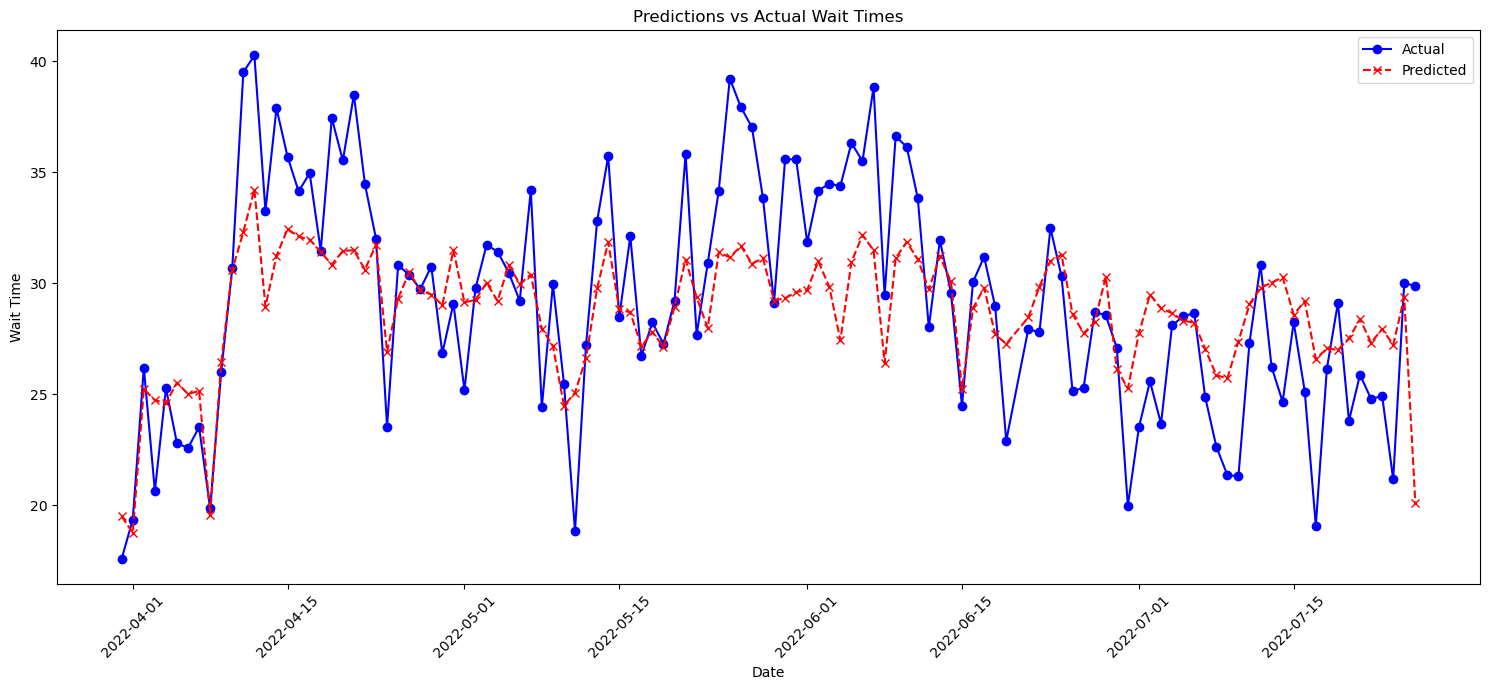

In [49]:
model.fit(X_train_total, y_train_total)

# Predict
y_pred_total = model.predict(X_test_total)


mape = mean_absolute_percentage_error(y_test_total, y_pred_total)
print(f'Mean Absolute Percentage Error: {mape}')

y_pred_series = pd.Series(y_pred_total, index=y_test_total.index)

# Now plot with the correct indexes
plt.figure(figsize=(15, 7))
plt.plot(y_test_total.index, y_test_total, label='Actual', color='blue', marker='o')
plt.plot(y_pred_series.index, y_pred_series, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Predictions vs Actual Wait Times')
plt.xlabel('Date')
plt.ylabel('Wait Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [52]:
feature_importance = model.feature_importances_
features = X_train_total.columns


feature_names = X_train_total.columns
indices = np.argsort(feature_importance)[::-1]

# Create a DataFrame with sorted feature importances and corresponding variable names
sorted_feature_importance = feature_importance[indices]
sorted_variable_names = [feature_names[i] for i in indices]

feature_importances_df = pd.DataFrame({'Variable': sorted_variable_names, 'Importance': sorted_feature_importance})

In [51]:
feature_importances_df

,Variable,Importance
0,ATTENDANCE,0.806150
1,day_of_year,0.018516
2,IS NIGHT SHOW,0.014233
3,IS PARADE 1,0.013892
4,GUEST CARRIED,0.013314
5,ATTRACTION NAME_Drop Tower,0.010526
6,ATTRACTION NAME_Free Fall,0.008400
7,ATTRACTION NAME_Oz Theatre,0.006705
8,HUMIDITY,0.004896
9,OPEN_TIME,0.004866


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Define the parameter grid to search
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a RandomForestRegressor model
model = RandomForestRegressor()

# Define the scorer for evaluating the models
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Define the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Set up the RandomizedSearchCV object with TimeSeriesSplit
random_search = RandomizedSearchCV(estimator=model,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   scoring=scorer,
                                   cv=tscv,  # Use TimeSeriesSplit here
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Assuming X_train_zip and y_train_zip are in chronological order
random_search.fit(X_train_total, y_train_total)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

# Predict using the best model
y_pred_best = random_search.predict(X_test_total)

# Evaluate the best model
mape_best = mean_absolute_percentage_error(y_test_total, y_pred_best)
print(f'Mean Absolute Percentage Error of the best model: {mape_best}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2

ON ENTIRE ATTRACTIONS

In [ ]:
df.sort_values('DATE', inplace = True)
df.set_index('DATE', inplace=True)
df.dropna(inplace=True)

In [ ]:
# Generate features from the DATE column (like day of week, month, etc.)

# Get dummies for categorical variables
df = pd.get_dummies(df, columns=['ATTRACTION NAME'])

# Select your features and target variable
X = df.drop(['DATE', 'WAIT TIME'], axis=1)  # Drop non-numeric and target columns
y = df['WAIT TIME']

# Split the data into training and testing sets (last 20% of days)
split_index = int(len(df) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Mean Absolute Percentage Error: 839097635740051.6


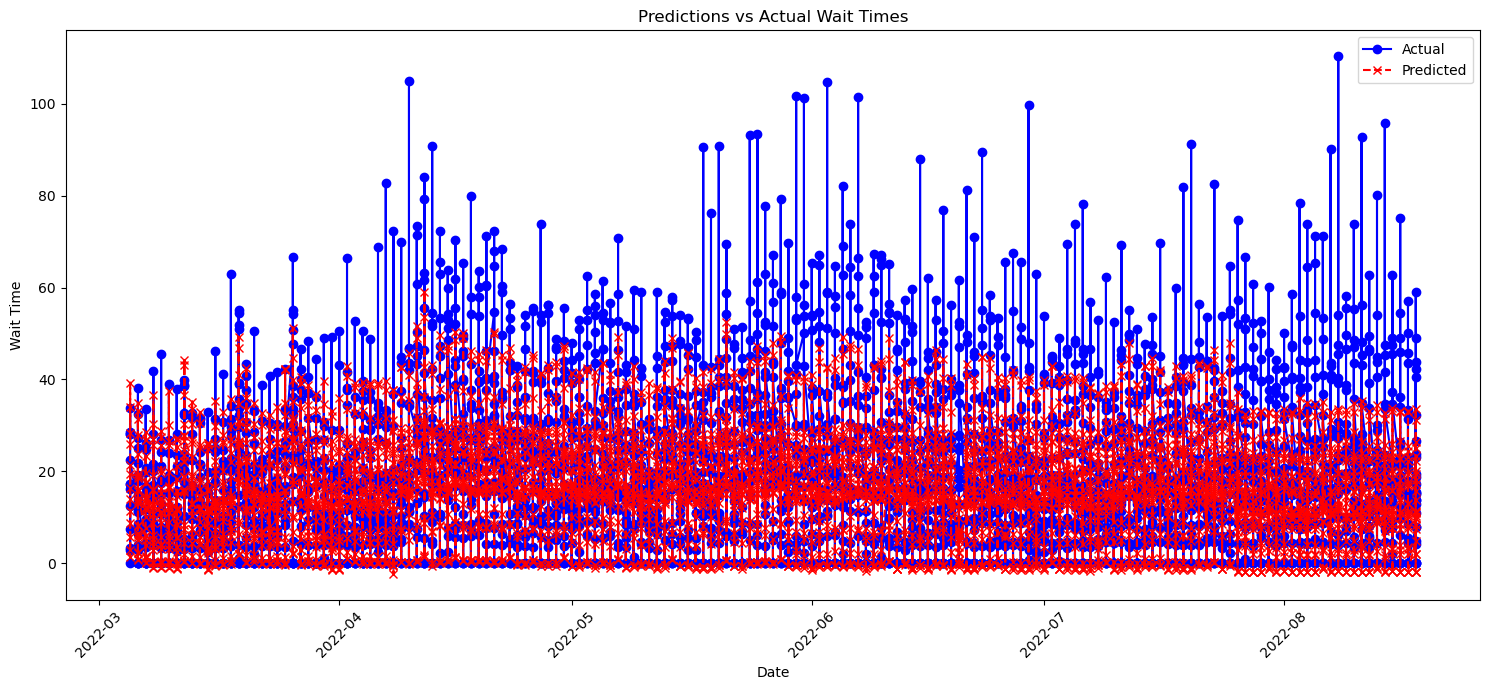

In [115]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 300)

# Fit the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

y_test_dates = df['DATE'][split_index:]

# Convert y_pred to a pandas Series with a datetime index
y_pred_series = pd.Series(y_pred, index=y_test_dates.index)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error: {mape}')

# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(y_test_dates, y_test, label='Actual', color='blue', marker='o')
plt.plot(y_test_dates, y_pred_series, label='Predicted', color='red', linestyle='--', marker='x')
plt.title('Predictions vs Actual Wait Times')
plt.xlabel('Date')
plt.ylabel('Wait Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()





In [88]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Define a range of hyperparameters for tuning
params = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'subsample': [0.7, 0.8, 0.9],
    'alpha': [0, 5, 10]
}

# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    model, param_distributions=params, n_iter=25, scoring='neg_mean_absolute_percentage_error',
    cv=tscv, verbose=1, random_state=42, n_jobs=-1)

# Fit the random search model
random_search.fit(X_train, y_train)

# Print best parameters
print(f"Best parameters: {random_search.best_params_}")

# Use the best estimator for prediction
y_pred = random_search.best_estimator_.predict(X_test)


,WAIT TIME,NB UNITS,GUEST CARRIED,CAPACITY,ADJUST CAPACITY,OPEN_TIME,REAL TIME ATTRACTION OPEN FOR 15MIN,REAL TIME ATTRACTION CLOSES FOR 15MIN,NB MAX UNITS,TEMPERATURE,TEMPERATURE FELT,TEMPERATURE MINIMUM,TEMPERATURE MAXIMUM,PRESSURE,HUMIDITY,WIND SPEED,WIND DEG,CLOUD PERCENTAGE,ATTENDANCE,day_of_week,month,year,ATTRACTION NAME_Bumper Cars,ATTRACTION NAME_Bungee Jump,ATTRACTION NAME_Circus Train,ATTRACTION NAME_Crazy Dance,ATTRACTION NAME_Dizzy Dropper,ATTRACTION NAME_Drop Tower,ATTRACTION NAME_Flying Coaster,ATTRACTION NAME_Free Fall,ATTRACTION NAME_Giant Wheel,ATTRACTION NAME_Giga Coaster,ATTRACTION NAME_Go-Karts,ATTRACTION NAME_Haunted House,ATTRACTION NAME_Himalaya Ride,ATTRACTION NAME_Inverted Coaster,ATTRACTION NAME_Kiddie Coaster,ATTRACTION NAME_Merry Go Round,ATTRACTION NAME_Oz Theatre,ATTRACTION NAME_Rapids Ride,ATTRACTION NAME_Roller Coaster,ATTRACTION NAME_Spinning Coaster,ATTRACTION NAME_Spiral Slide,ATTRACTION NAME_Superman Ride,ATTRACTION NAME_Swing Ride,ATTRACTION NAME_Vertical Drop,ATTRACTION NAME_Water Ride,ATTRACTION NAME_Zipline
count,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000,42340.000000
mean,12.652257,10.513470,80.708991,175.253081,154.980816,8.057022,7.752377,0.304645,16.035026,7.535127,5.376165,6.570233,8.556583,1017.159048,83.525866,4.238124,185.227399,70.641337,24338.656873,2.996410,6.226382,2019.843859,0.039915,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039915,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.039939,0.001677,0.039868,0.039915
std,15.224069,23.077252,86.034676,172.560373,152.310181,5.523778,5.389259,0.920950,28.904890,2.419683,3.023930,2.421894,2.410714,7.518035,7.989097,1.189770,50.522999,19.470952,22122.418842,1.999619,3.388631,1.348564,0.195762,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195762,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.195817,0.040916,0.195651,0.195762
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.714286,0.000000,0.000000,-4.142857,-9.135714,-4.978571,-3.135714,975.714286,37.357143,0.701429,8.071429,0.000000,-9991.000000,0.000000,1.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.534682,5.375491,6.569751,8.556166,1017.159478,83.524512,4.237857,185.225420,70.637711,0.000000,1.000000,3.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.142857,2.000000,63.303571,162.203022,144.508929,10.089286,9.732143,0.000000,5.000000,7.534682,5.375491,6.569751,8.556166,1017.159478,83.524512,4.237857,185.225420,70.637711,23383.000000,3.000000,6.000000,2020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.839286,11.483631,123.553570,246.42881

In [81]:
df.dtypes.any() not in [int, float, bool]

True